 # FashionMNIST

 ## Задание 7.2

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

На практике построим нейронную сеть для классификации картиной. В качестве входных данных используются картинки одежды (в градациях серого, то есть цветовых каналов не 3, а 1). По входной картинке нужно предсказать тип одежды.

In [1]:
# !pip install torchvision

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision

Скачаем обучающую и контрольную выборки.

In [91]:
import torch
from torchvision import datasets, transforms
import helper

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor()])

#transforms.ToTensor() convert our image to a tensor
#transforms.Normalize() will normalizae our image with provided mean and sd values

# Download and load training data

trainset = datasets.FashionMNIST('./data',download=True, train= True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size= 16, shuffle=True)

# Download and load test data
testset = datasets.FashionMNIST('./data',download=True, train= False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size= 16, shuffle=True)

Каждая картинка имеет класс от 0 до 9, расшифровка меток класса:  

|class_id|class_name|
|----|----|
|0| T-shirt/top|
|1| Trouser|
|2| Pullover|
|3| Dress|
|4| Coat|
|5| Sandal|
|6| Shirt|
|7| Sneaker|
|8| Bag|
|9| Ankle boot| 

<h2 style="text-align: center;"><b>Задание</b></h2>

Посмотрите на датасет.
* Сколько картинок в train? В test?
* Равномерно ли распределено количество объектов разных классов в train датасете (это можно понять, поработав с полем `train_data` у переменной `trainset`)? в test?
* Выведите несколько картинок с помощью `pyplot`

Используя материалы семинаров по многослойным  и свёрточным сетям, напишите:
1.  Многослойную нейронную сеть MLP (Multi-Layer Perceptron) классифицирующую этот датасет
2. Свёрточную сеть, классифицирующую этот датасет
3. Сравните их качество (по графикам лосса и по Accuracy Score)

Если качество, которое получается у  нейросети, выше 95%, то Вы решили задачу с точностью, которую можно использовать в жизни.

In [85]:
trainset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [86]:
testset

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

60 тысяч картинок в трейне и 10 тысяч в тесте

In [45]:
trainset.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [46]:
for i in trainset.targets.unique():
    print(f'{i} class has {(trainset.targets == i).sum()} entries')

0 class has 6000 entries
1 class has 6000 entries
2 class has 6000 entries
3 class has 6000 entries
4 class has 6000 entries
5 class has 6000 entries
6 class has 6000 entries
7 class has 6000 entries
8 class has 6000 entries
9 class has 6000 entries


In [47]:
for i in trainset.targets.unique():
    print(f'{i} class has {(testset.targets == i).sum()} entries')

0 class has 1000 entries
1 class has 1000 entries
2 class has 1000 entries
3 class has 1000 entries
4 class has 1000 entries
5 class has 1000 entries
6 class has 1000 entries
7 class has 1000 entries
8 class has 1000 entries
9 class has 1000 entries


Распределение классов в трейне и тесте одинаково равномерное

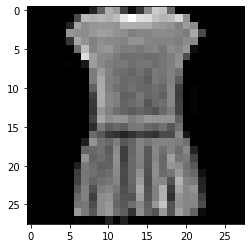

In [8]:
plt.imshow(trainset.data[3], cmap='gray');

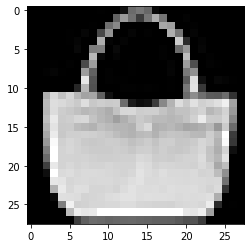

In [9]:
plt.imshow(trainset.data[100], cmap='gray');

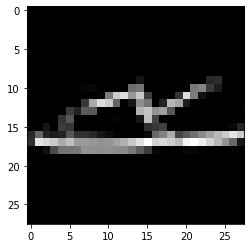

In [10]:
plt.imshow(trainset.data[32115], cmap='gray');

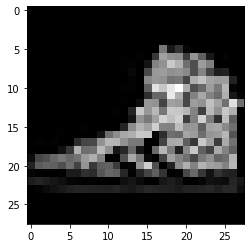

In [11]:
plt.imshow(testset.data[6666], cmap='gray');

torch.Size([16, 784])

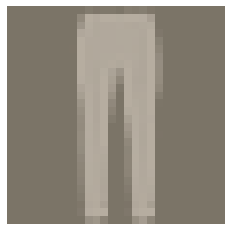

In [92]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:])
image.view(image.shape[0],-1).shape

In [93]:
image.view(image.shape[0],-1).shape

torch.Size([16, 784])

### MLP

In [94]:
#Network parameters

input_size = 784 #i.e 28*28*1 
hidden_size = [256,128,64]
out_size = 10

In [95]:
from torch import nn
from torch.nn import NLLLoss
from torch.optim import SGD

model = nn.Sequential(
nn.Linear(input_size,hidden_size[0]),
nn.ReLU(),
nn.Linear(hidden_size[0],hidden_size[1]),
nn.ReLU(),
nn.Linear(hidden_size[1],hidden_size[2]),
nn.ReLU(),
nn.Linear(hidden_size[2],out_size),
nn.LogSoftmax(dim=1)
)

criterion = torch.nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(),lr=0.001)

In [96]:
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=10, bias=True)
  (7): LogSoftmax(dim=1)
)


In [97]:
epochs = 15
losses = []
training_losses = []

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
    
        #Flatten the image into a 784 long vector
    
        images = images.view(images.shape[0],-1) #sqash the image in to 784*1 vector
    
        #reset the default gradients
        optimizer.zero_grad()
    
        # forward pass
        output = model(images)
        loss = criterion(output,labels)
    
    
        #backward pass calculate the gradients for loss
        loss.backward()
    
        # update the parameters
        optimizer.step()
    
        running_loss = running_loss+loss.item()
        losses.append(running_loss)
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")
        training_losses.append(running_loss/len(trainloader))

Training loss: 2.242280814743042
Training loss: 1.669481623649597
Training loss: 1.0906645882288615
Training loss: 0.8593255668242772
Training loss: 0.7593165506482125
Training loss: 0.6969124824404717
Training loss: 0.6477098307053248
Training loss: 0.6092365945736568
Training loss: 0.5809352363785107
Training loss: 0.5576102827568848
Training loss: 0.5386338463564714
Training loss: 0.5228484581728776
Training loss: 0.5083753608097633
Training loss: 0.49631312820514045
Training loss: 0.48609402765432996


tensor([[ -4.0847,  -3.8691,  -8.9222,  -0.0440,  -5.7519, -18.3729,  -6.3858,
         -20.7304,  -8.0457, -20.1993]])
tensor([[1.6829e-02, 2.0878e-02, 1.3339e-04, 9.5698e-01, 3.1767e-03, 1.0490e-08,
         1.6852e-03, 9.9288e-10, 3.2048e-04, 1.6886e-09]])


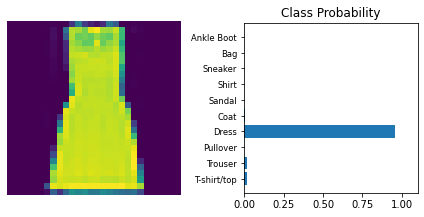

In [98]:
dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.resize_(1, 784)

#turn off the gradients
with torch.no_grad():
    print(model(img))
    logps = model(img)

ps = torch.exp(logps)
print(ps)

# Plot the image and probabilities
helper.view_classify(img.resize_(1, 28, 28), ps, version='Fashion')



In [99]:
X_test = testset.data.resize_(10000, 1, 784)

In [100]:
X_test = X_test.float()

In [101]:
preds = []

for i in range(10000):
    temp = model(X_test[i])
    temp_2 = torch.exp(temp)
    temp_2 = temp_2.detach().numpy()
    preds.append(np.argmax(temp_2))

In [102]:
print(len(preds))

10000


In [103]:
from sklearn.metrics import accuracy_score

accuracy_score(testset.targets, preds)

0.7543

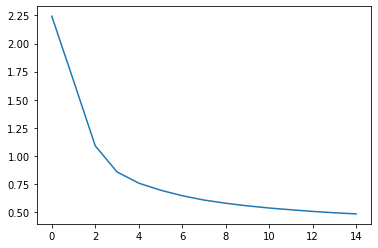

In [104]:
plt.plot(training_losses)

In [105]:
for data in trainloader:
    print(len(data))
    print('Images:',data[0].shape)
    print('Labels:', data[1].shape)
    break

2
Images: torch.Size([16, 1, 28, 28])
Labels: torch.Size([16])


In [106]:
for data in testloader:
    images, labels = data
    print(images.shape)
    break

torch.Size([16, 1, 1, 784])


In [107]:
trainloader.dataset.data.shape

torch.Size([60000, 28, 28])

In [124]:
testloader.dataset.data.shape

torch.Size([10000, 28, 28])

In [111]:
import torch.nn as nn
import torch.nn.functional as F  # Functional

In [112]:
# Заметьте: класс наследуется от nn.Module
class SimpleConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора родителя
        super(SimpleConvNet, self).__init__()
        # необходмо заранее знать, сколько каналов у картинки (сейчас = 1),
        # которую будем подавать в сеть, больше ничего
        # про входящие картинки знать не нужно
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        # out_channels - это количество фильтров, которые применятся для свёртки
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(4 * 4 * 16, 120)  # см. примечание ниже
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = x.view(-1, 4 * 4 * 16)  #  см. примечание ниже
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [113]:
from tqdm import notebook # это для прогресс-баров

In [114]:
training_losses_2 = []

# объявляем сеть
net = SimpleConvNet()

# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# итерируемся
for epoch in notebook.tqdm(range(15)):

    running_loss = 0.0
    for i, batch in enumerate(notebook.tqdm(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch
        
        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        # выведем качество каждые 2000 батчей
#         if i % 2000 == 1999:
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")
        training_losses_2.append(running_loss/len(trainloader))        

print('Обучение закончено')

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

Training loss: 0.9197903762817383


  0%|          | 0/3750 [00:00<?, ?it/s]

Training loss: 0.6588631177663803


  0%|          | 0/3750 [00:00<?, ?it/s]

Training loss: 0.5946219441771508


  0%|          | 0/3750 [00:00<?, ?it/s]

Training loss: 0.5451593482454618


  0%|          | 0/3750 [00:00<?, ?it/s]

Training loss: 0.5066083413531383


  0%|          | 0/3750 [00:00<?, ?it/s]

Training loss: 0.4755987304399411


  0%|          | 0/3750 [00:00<?, ?it/s]

Training loss: 0.45032491372923056


  0%|          | 0/3750 [00:00<?, ?it/s]

Training loss: 0.4291676759421825


  0%|          | 0/3750 [00:00<?, ?it/s]

Training loss: 0.4112590188120802


  0%|          | 0/3750 [00:00<?, ?it/s]

Training loss: 0.3949776329378287


  0%|          | 0/3750 [00:00<?, ?it/s]

Training loss: 0.381580908643206


  0%|          | 0/3750 [00:00<?, ?it/s]

Training loss: 0.3683535403271516


  0%|          | 0/3750 [00:00<?, ?it/s]

Training loss: 0.3574841670706868


  0%|          | 0/3750 [00:00<?, ?it/s]

Training loss: 0.34821541538884243


  0%|          | 0/3750 [00:00<?, ?it/s]

Training loss: 0.33972181465774776
Обучение закончено


In [116]:
classes = tuple(str(i) for i in range(10))

In [125]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 81 %
Accuracy of     1 : 95 %
Accuracy of     2 : 80 %
Accuracy of     3 : 85 %
Accuracy of     4 : 81 %
Accuracy of     5 : 94 %
Accuracy of     6 : 66 %
Accuracy of     7 : 94 %
Accuracy of     8 : 97 %
Accuracy of     9 : 96 %


In [136]:
predicted

tensor([7, 1, 8, 1, 9, 9, 6, 9, 4, 8, 3, 2, 9, 6, 7, 8])

In [137]:
labels

tensor([7, 1, 8, 1, 9, 9, 2, 9, 4, 8, 3, 2, 9, 6, 7, 8])

In [135]:
(predicted == labels)

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True])

In [145]:
all_labels = []
all_preds = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images)
        _, predicted = torch.max(y_pred, 1)
        all_labels.extend(labels.numpy())
        all_preds.extend(predicted.numpy())
print(len(all_labels))

10000


In [148]:
accuracy_score(all_labels, all_preds)

0.8695

У MLP `accuracy_score` был в районе 0.75

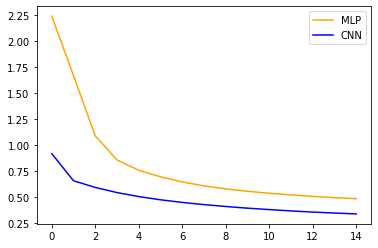

In [153]:
plt.plot(training_losses, c='orange', label="MLP")
plt.plot(training_losses_2, c='blue', label="CNN")
plt.legend(loc="upper right")
plt.show();